# TP-CBIR (Content Based Image Retrieval)
# -----------------------------------------------------------------

## Réalisé par:
##                    - KANA NGUIMFACK Kévin
##                    - OUEDRAOGO Wend-Panga Jérémie

#### Il est question dans ce travail, d'implementer un système de recherche d'images par le contenu (CBIR), compte tenu des limites de systèmes de recherche par mots clés, très fastidieux pour une base énorme car annotation à la main, donc perte de temps, et performance influencée par les erreurs humaines. Alors nous utilisons cette approche automatisé (CBIR), permettant la recherche d'images, dans une base préalablement indexé,  à partir des descripteurs d'une image requête préalablement calculées, en utilisant une métrique de similarités. Nous exploitons ici, dans les sources multimédia images, les informations de couleur dans l'espace  HSV(Hue Saturation Value) et de forme. Le dataset utilisé, est COIL-100, de 100 classes, avec un total de 7200 images.

# Baseline
# ------------------------------

### 1- Chargement de tous les fichiers de notre dataset (100 classes, 72 images / classe)
### 2- Définition de fonctions des signatures (caractéristiques)
#####    - Descripteurs de couleur: Histogramme de couleur (HSV)
#####    - Descripteurs de forme: Calcul des	moments	et	des	caractéristiques	
### 3- Indexation de la base de données COIL-100
#####    - Sauvegarde des descripteurs sous format binaire pickle(.pkl)
### 4- Definition des métrique d'évaluation de similarité
#####    - métrique d'évaluation de l'histogramme de couleurs: la	méthode	du	Chi-2	(ou	Chi-square)	
#####    - métrique d'évaluation de l'histogramme de couleurs: la	méthode	distance euclidienne
#####    - métrique globale: la	somme pondéré des métriques ci-dessous 
######   Distance	=	ω1	∗	dist_couleur	+	ω2	∗	dist_forme		,  Avec	ω1+ω2	=1.(par	défaut	ω1=	ω2	=	0,5)	
### 5- Recherche d'images à partir d'une image requête 
#####   -Nous retournerons les 10 premiers resultas, selon un ordre croissante de similarité (la similarité est d'autant forte que la métrique est plus petite)
### 6- Evaluation sur 100 images requêtes ( 1 image / classes)

# Importation des libraries, pour notre travail

In [1]:
import cv2
import numpy as np
import pandas as pd
import glob
from math import copysign, log10
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os

# Chargement dataset COIL-100

### Récupération de chaque fichier image, en utilisant la librairies glob 

In [2]:
db_path='./coil-100/'

images_filenames  =  glob.glob( db_path +'*.png')
images_filenames

['./coil-100/obj20__105.png',
 './coil-100/obj90__325.png',
 './coil-100/obj93__85.png',
 './coil-100/obj55__195.png',
 './coil-100/obj11__280.png',
 './coil-100/obj81__340.png',
 './coil-100/obj30__330.png',
 './coil-100/obj86__80.png',
 './coil-100/obj83__60.png',
 './coil-100/obj89__20.png',
 './coil-100/obj72__320.png',
 './coil-100/obj31__10.png',
 './coil-100/obj85__70.png',
 './coil-100/obj94__220.png',
 './coil-100/obj25__280.png',
 './coil-100/obj16__60.png',
 './coil-100/obj56__40.png',
 './coil-100/obj3__160.png',
 './coil-100/obj36__130.png',
 './coil-100/obj79__125.png',
 './coil-100/obj77__275.png',
 './coil-100/obj56__235.png',
 './coil-100/obj56__245.png',
 './coil-100/obj72__215.png',
 './coil-100/obj91__50.png',
 './coil-100/obj72__0.png',
 './coil-100/obj93__120.png',
 './coil-100/obj86__135.png',
 './coil-100/obj9__320.png',
 './coil-100/obj36__280.png',
 './coil-100/obj50__265.png',
 './coil-100/obj79__115.png',
 './coil-100/obj95__190.png',
 './coil-100/obj58__135

In [3]:
print("COIL-100, nombre d'images: {}".format(len(images_filenames)))

COIL-100, nombre d'images: 7200


# Définition de fonctions des signatures (caractéristiques)

### __Step__ 0: Reduction de la quantification
##### Les valeurs de l'images étant comprises entre 0  et 255, il s'agit de leur ramené entre 0 et 32. A cet effet nous avons eu à choisir 32 valeurs.

#### La fonction reduceQuantification, prend en paramètres, une images couleur de quantification 0-255 et la nouvelle valeur maximale de quantification prédéfinie (quantification_value, ici fixé à 32), et retourne une image couleur de quantification 0-32

In [4]:
# reduction of number value
quantification_value = 32

def reduceQuantification(nb_values = quantification_value , image = None):
    # Diviser l'image en ses differents channel, rouge, vert, et blue.
    R, G, B= cv2.split(image)
    
    for i in range(B.shape[0]): # B.shape[0]: hauteur de l'image
        for j in range(B.shape[1]): # B.shape[1]: largeur de l'image
            B[i][j] = round(B[i][j] * nb_values / 255)
            G[i][j] = round(G[i][j] * nb_values / 255)
            R[i][j] = round(R[i][j] * nb_values / 255)
    
    # Fusionner les differentes channel pour obtenir l'image couleur initiale
    image = cv2.merge((R, G, B))        
    return image

### __Step__ 1: Fonction d'extraction d' extraction des caractéristiques de couleurs (histogramme couleur)
#### Pour une image donnée, nous reduisons dans un premier temps sa quantification de 0-32. Puis nous convertissons l'image dans l'espace couleur HSV (H angle variant de 0-180, S et V de 0-32), avant de calculer son histogramme 3D. 

#### Les fonction Histo3DFeatureColor et Histo3DFeatureColor, prennent en paramètres, une image couleur et les bacs d'histogramme prédéfinis (8 bins pour H, 12 bins pour S et 3 bins pour V), et retourne un vecteur de caractéristique d' histogramme couleur de taille 288.

In [5]:
_bins = (8,12,3)

def Histo3DFeatureColor(image = None, bins= _bins):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([image], [0, 1, 2], None, bins,[0, 180, 0, 32, 0, 32])
    # Normalisation de l'histogramme, pour reduire l'influence du nombre de pixels pour chaque bins.
    features_vector = cv2.normalize(hist, hist).flatten()
    return np.asarray(features_vector)

### __Step__ 2: Fonction d'extraction des caractéristiques de forme (Moments de Hu)
#### L'image couleur cible sera préalablement convertir en niveau de gris. Puis calculer les moments et les caractéristiques de l'image donnée, le moment de Hu permet d'estimer la forme de l'object dans une 'image. Les caractéristiques de Hu définis, au nombre de 7, seront déduits des moments précalculés.

#### Etapes:
##### - convertion image en niveau de gray.
##### - Utiliser une approche de segmentation par seuillage  (resultat image noir-blanc, image binaire).
##### - Calcul des moments associés à l'image ( la moyenne pondérée des intensités de pixels de l'image).
##### - Déterminer les caractéristiques du Moment de Hu (au nombre de 7), de l'object.
#### Les invariants de moment Hu sont calculés en utilisant des moments centraux invariants aux transformations d'image. Les 6 premiers moments se sont avérés être invariants à la translation, à l'échelle, à la rotation et à la réflexion. Et le signe du 7ème moment change pour la réflexion de l'image.

#### La fonction ObjectFeatureShape, prend en paramètre une image couleur, et retourne les caractéristiques de Hu associés à l'image.

In [6]:
def ObjectFeatureShape(image = None):
    # convertir l'image en niveau de gris
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # seuillage adaptative de l'image
    _, gray_th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # calcul des moments centraux de l'images
    moments = cv2.moments(gray_th_otsu)
    # calcul des moments de Hu (7) en utilisants les moments centraux
    Hu_moments = cv2.HuMoments(moments)
    """
        Notons que les moments de Hu, ainsi obtenus, sont parfois très variables à l'echelle.
        Afin de palier à ce problème, nous les ramenons sur la même echelle, en effectuant 
        une transformation logarithmique decimale, tel que H(i) = -sign(hi)log10(|hi|)
    """
    for i in range(0,7):
        Hu_moments[i] = -1 * copysign(1.0, Hu_moments[i]) * log10(abs(Hu_moments[i]))
        
    return np.asarray(Hu_moments.flatten())

# Indexation de la base de données COIL-100

# -----------------------------------------------------------------
### Calcul des différentes signatures, sur notre dataset COIL-100

#### La fonction DatasetIndexing, prend en paramètres, l'ensemble des fichiers de notre dataset. 
#### Pour chaque fichier image, nous procédons comme suite:
##### - Lecture du fichier image
##### - Extraction des caractéristiques de couleurs et de forme
##### - Mise à jour de la structure de données, data prédéfinir
#### En fin sauvegarde du fichier data au format binaire pickle(.pkl).

In [7]:
def DatasetIndexing(images_files = images_filenames):
    """
        Definition de notre structure de données pour la sauvegarde des signatures 
        (histogramme de couleurs + descripteurs de Hu) et des noms d'images associés
    """
    # si le fichier d'indexation du dataset n'est pas crée, alors la section est éxécutée
    if not (os.path.isfile("IndexingDataset2.pkl")):
        data = pd.DataFrame(columns=("name_file","features_color", "features_shape"))
        for filename in images_files:
            # lire le fichier image
            _img = cv2.imread(filename)
            _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
            img = reduceQuantification(nb_values = quantification_value , image = _img)
            # extraction des caractéristiques de couleurs de l'image
            features_color = Histo3DFeatureColor(image = img, bins = _bins)
            # extraction des caractéristiques de forme de l'image
            features_shape = ObjectFeatureShape(image = img)
            # pour contenir les informations courantes, avant insertion dans data
            dic = dict()
            fn = filename.split('/') # séparation du chemin relatif par le séparateur '/'

            dic["name_file"] = fn[2] #extraction du nom de l'image 
            dic["features_color"] = features_color
            dic["features_shape"] = features_shape

            # mise à jour de variable de stockage data 
            data = data.append(dic, ignore_index=True)

        # Sauvegarde du dataset après indexation
        data.to_pickle("IndexingDataset2.pkl")

In [8]:
DatasetIndexing(images_files = images_filenames)

### Prévisualisation de la sauvegarde

In [9]:
indexed_db = pd.read_pickle('IndexingDataset2.pkl')

In [10]:
# affichage des 10 premiers lignes
indexed_db.head(10)

,name_file,features_color,features_shape
0,obj20__105.png,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.001966129607334, 6.579216781115412, 10.2606..."
1,obj90__325.png,"[0.999509, 0.019738745, 0.0139816115, 0.0, 0.0...","[2.804446450463385, 5.865106807089411, 9.22343..."
2,obj93__85.png,"[0.9994827, 0.026354518, 0.0, 0.0, 0.0, 0.0, 0...","[2.9941863659821424, 6.323365186405546, 9.7935..."
3,obj55__195.png,"[0.96931136, 0.03377185, 0.10279678, 0.0, 0.0,...","[3.15523197868933, 7.743223982295529, 10.77530..."
4,obj11__280.png,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.144574987206589, 7.00370220491629, 10.67299..."
5,obj81__340.png,"[0.99993813, 0.0021723255, 0.00016710196, 0.0,...","[2.694029322086657, 8.746101882102247, 8.51452..."
6,obj30__330.png,"[0.99999917, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[3.0454146567097222, 6.769891867439611, 10.007..."
7,obj86__80.png,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.087784648081366, 6.8561580029635305, 10.805..."
8,obj83__60.png,"[0.99999994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[3.174572184563596, 7.620239643099023, 10.4049..."
9,obj89__20.png,"[0.95317864, 0.24303052, 0.07207749, 0.0, 0.0,...","[3.009894249703678, 6.648599800363823, 9.85820..."


In [11]:
# afficher nom première image
indexed_db["name_file"][0]

'obj20__105.png'

In [12]:
# afficher features_color première image
indexed_db["features_color"][0]

array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.5898251e-04,
       0.0000000e+00, 0.0000000e+00, 1.5898251e-04, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [13]:
# afficher nom features_shape première image
indexed_db["features_shape"][0]

array([  3.00196613,   6.57921678,  10.26060017,  10.48310894,
        20.90758846,  13.77333282, -21.18852605])

In [14]:
# taille caractéristique couleurs
indexed_db["features_color"][0].shape

(288,)

In [15]:
# taille caractéristiques forme
indexed_db["features_shape"][0].shape

(7,)

# Definition des métrique d'évaluation de similarité

### __Step__ 1: Métrique d'évaluation de l'histogramme de couleurs: la méthode du Chi-2 (ou Chi-square)
#### Nous utilisons ici la fonction Chi-2, qui tire son nom de la statistique de test du chi carré de Pearson, utilisée pour comparer les distributions de probabilité discrètes.

#### Notre fonction, chi2Distance prend en paramètres, une descripteur couleur de notre base indexée, et le descripteur couleur de l'image requête, et un dernier paramètre eps permettant d'éviter les division par zéro. 
#### Elle retourne la distance descrivant la similarité entre les deux histogrammes, plus elle est grande et moins ils sont similaires.

In [16]:
def Chi2Distance(features_color_db = None, features_color_query = None, eps = 1e-10):
    # calcul de la distance chi-squared
    dist_chi2 = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) 
                              for (a, b) in zip(features_color_db, features_color_query)])
    
    return dist_chi2

### __Step__ 2: Métrique d'évaluation de forme (Moments de Hu): la méthode distance euclidienne

#### Nous calculons la distance euclidienne entre  deux descripteurs de Hu, respectivement  un descripteur de reférence dans notre base indexée et le descripteur de l'image requête.
#### La fonction, DistanceEuclidienne prend ses 2 paramètres, et retourne la distance descrivant la similarité entre les deux moments de Hu, plus elle est grande et moins ils sont similaires.

In [17]:
def DistanceEuclidienne(features_shape_db = None, features_shape_query = None):
    # calcul de la distance euclidiene
    dist = np.sum([((a - b) ** 2) for (a, b) in zip(features_shape_db, features_shape_query)])
    dist = np.sqrt(dist)
    
    return dist

### __Step__ 3: Métrique globale: la somme pondéré des métriques ci-dessous
#### Distance = ω1 ∗ dist_couleur + ω2 ∗ dist_forme , Avec ω1+ω2 =1.(par défaut ω1= ω2 = 0,5)
#### La fonction Distance, prend en paramètres les métriques de signature de couleur et de forme, de l'image requête par rapport aux signatures couleur et forme d'une image donnée de la base modèle. Et elle retorne la distance pondérée calculée.

In [44]:
# Initialisation des poids
w1 = 0.20
w2 = 0.80

def Distance(dist_color = None, dist_shape = None):
    # Calcul de la métrique pondérée, à par des métriques de signature de couleur et de forme
    distance = w1 * dist_color + w2 * dist_shape
    
    return distance

# Recherche d'images similaires, à partir d'une image requête
### Definition de la fonction de recherche. 
#### La fonction RechercheImagesFromImageReq, prend en paramètres l'image requête et l' ensemble d'images de notre base indexée, et retourne les 10 meilleurs resultats, dans l'ordre de similarités la plus forte (selon les distance croissante).

In [19]:
# nombre maximum de resultats les plus proches à afficher
NB_RESULTATS = 10
def RechercheImagesFromImageReq(path_image_query = None, indexed_db = indexed_db):
    # lire image requête
    img_query = cv2.imread(path_image_query)
    # convertir dans l' espace RGB
    img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)
    # reduction de la quantification
    img_query = reduceQuantification(nb_values = quantification_value , image = img_query)
    # Extraction caractéristique couleur et forme, de l'image requête
    query_features_color = Histo3DFeatureColor(image=img_query, bins=_bins)
    query_features_shape = ObjectFeatureShape(image=img_query)
    # draw histogramme image query
    displayHisto(img_origine = img_query, Histo = query_features_color)
    # supprimer l'image requête de la mémoire
    del img_query
    """
     list_resultats contenient,la distance de similarité de chaque image reférence 
     par rapport à l'image requête 
    """
    list_resultats = list()
    # mesure de similarités
    for ft_color_db, ft_shape_db in zip(indexed_db["features_color"].values.tolist(), 
                                              indexed_db["features_shape"].values.tolist()):
        # calcul métrique couleur
        dist_color = Chi2Distance(features_color_db=ft_color_db, features_color_query=query_features_color)
        # calcul métrique forme
        dist_shape = DistanceEuclidienne(features_shape_db=ft_shape_db, features_shape_query=query_features_shape)
        # calcul métrique pondérée
        distance = Distance(dist_color=dist_color, dist_shape=dist_shape)
        # mise à jour des resultats
        list_resultats.append(distance)
        
    """
    trier les resultats dans l'ordre croissant, par rapport aux indices 
    (la plus petite distance à son indice en première position et la plus grande en dernière position)
    """
    results_ord_indices = np.argsort(list_resultats)
    # garder les 10 premiers resultats (les meilleurs)
    results_ord_indices = results_ord_indices[:10]
    # recupérer la liste de noms d'images indexées
    noms_images_db = np.asarray(indexed_db["name_file"])
    # recupérer les noms images resultats
    noms_images_resultats = noms_images_db[results_ord_indices]
    # convertir liste distance en array
    list_resultats = np.array(list_resultats)
    # recupérer les distances images resultats
    distances_resultats = list_resultats[results_ord_indices]
    
    # retourner les resultats noms et distance de la requête
    return noms_images_resultats, distances_resultats


"""
    Fonction d'affichage histogramme de l'image requête
""" 
def displayHisto(img_origine = None, Histo = None):
  plt.subplot(221), plt.imshow(img_origine)
  plt.subplot(222), plt.plot(Histo[:32], color='b'), plt.plot(Histo[32:64], color='g'),plt.plot(Histo[64:96], color='r')
  plt.xlim([0,32])

  plt.show()



"""
    Fonction d'affichage resultats
""" 
def afficheResultats(image_query = None, resultats_noms = None, resultats_dist = None):
    print("> recherche  --input  {}".format(image_query),"\n")
    print("Images                     Distances")
    print("------                     ---------")
    for nom, dist in zip(resultats_noms, resultats_dist) :
         print("{}\t\t {}\n".format(nom, dist))

### Recherche à partir d'une image requête

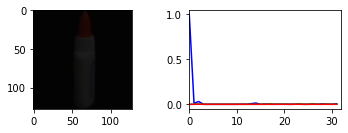

In [45]:
# nous utilisons prémière une image
path_image_query = "./coil-100/obj33__95.png"

resultats_noms, resultats_dist = RechercheImagesFromImageReq(path_image_query=path_image_query, indexed_db=indexed_db)

In [46]:
afficheResultats(image_query = path_image_query, resultats_noms = resultats_noms, resultats_dist = resultats_dist)

> recherche  --input  ./coil-100/obj33__95.png 

Images                     Distances
------                     ---------
obj33__95.png		 0.0

obj33__100.png		 0.11902106527298129

obj33__285.png		 0.22568038182160957

obj15__325.png		 0.27189854242185646

obj84__170.png		 0.3156285479664753

obj22__270.png		 0.3405014610537773

obj33__290.png		 0.3436096258862119

obj33__105.png		 0.37307794384376636

obj33__90.png		 0.38107605273653494

obj33__280.png		 0.39938942373237935



# Evaluation sur 100 images requêtes ( 1 image / classes)
### La fonction evaluate, retourne une matrice de confusion de taille 100 x 100, chaque ligne correspond à l'image de test utilisé, et les colonnes vont contenir le nombre d'occurence pour chaque image resultat parmi 10.

In [22]:
test_path = './test/'
def evaluate(test = test_path, indexed_db = indexed_db):
    cf = np.zeros((100,100))
    images_filenames_test  =  glob.glob( test_path +'*.png')
    # faire la recherche pour chaque image de test et mettre à jour la matrice de confusion
    for fname_test in images_filenames_test:
        # recupérer l'id de l'image test
        id_test = getId(fname_test)
        # recherche d'images similaires
        resultats_noms, _ = RechercheImagesFromImageReq(path_image_query = fname_test, indexed_db = indexed_db)
        # Mise à jour de la matrice de confusion
        cf = UpdateConfMatrix(cf = cf, id_test = id_test, resultats = resultats_noms)
    
    # returner la matrice de confusion
    return cf

"""
   Fonction pour recuperer l'id de l'image à partir de son nom
"""
def getId(name_file = None):
    n_file = name_file.split('__')
    n_id = n_file[0].split('j')
    id = int(n_id[1])
    return id

"""
   Fonction pour mettre à jour la matrice confusion 100X100, de 0-99
"""
def UpdateConfMatrix(cf=None, id_test = None, resultats = None ):
    for res in resultats:
        # recuperer l'id du nom de fichier resultat
        id_res = getId(res)
        # incrementer la case correspondant de 1 pour le resultat prédire, à partir de id_test
        cf[id_test-1][id_res-1] = cf[id_test-1][id_res-1] + 1
    
    return cf

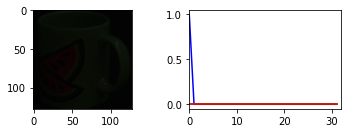

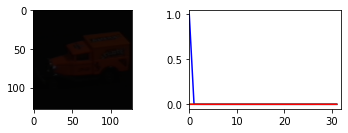

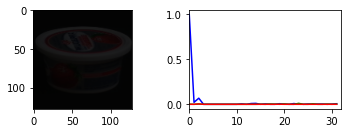

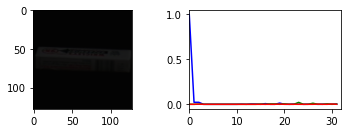

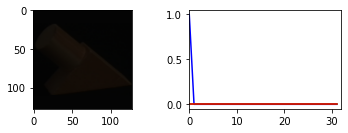

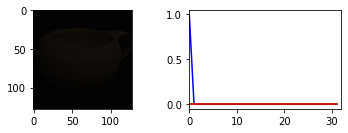

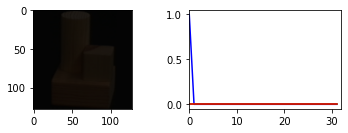

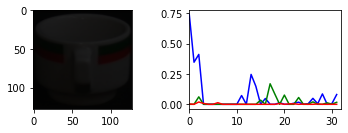

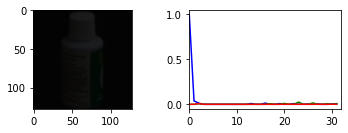

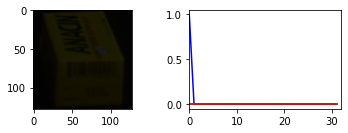

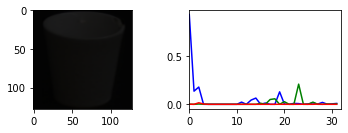

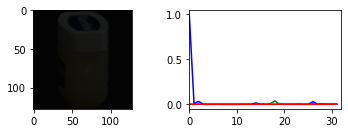

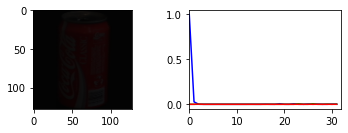

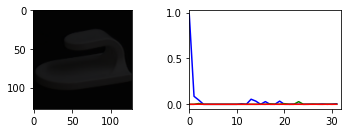

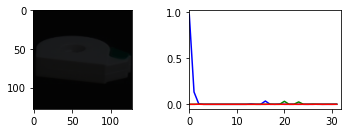

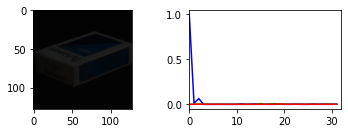

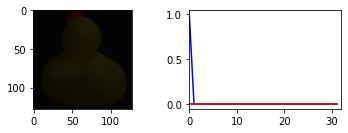

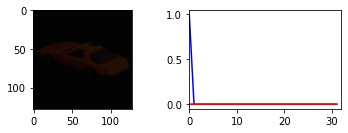

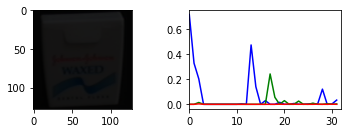

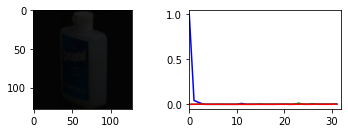

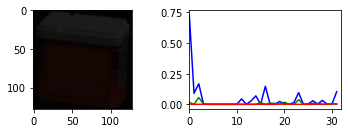

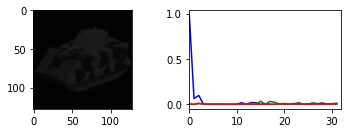

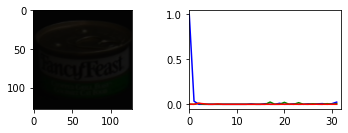

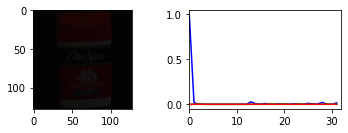

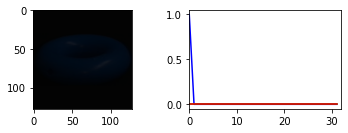

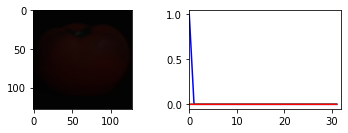

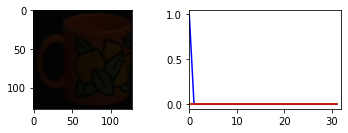

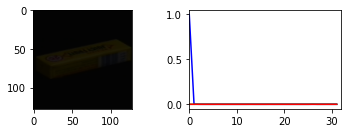

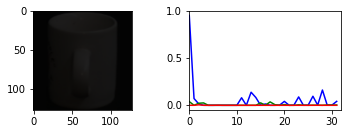

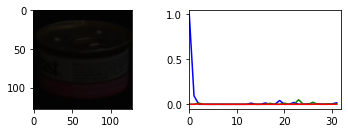

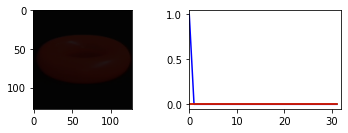

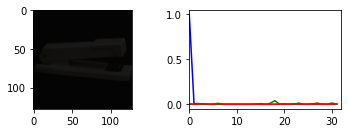

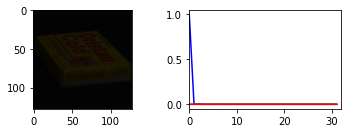

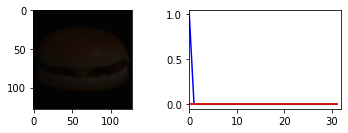

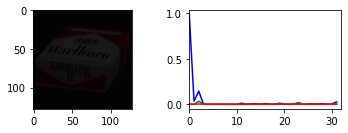

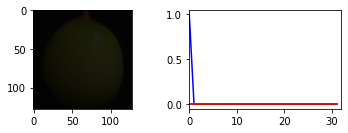

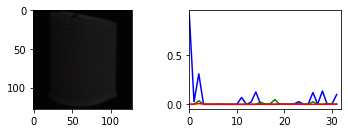

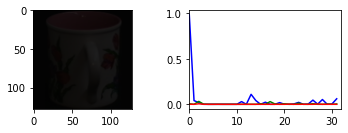

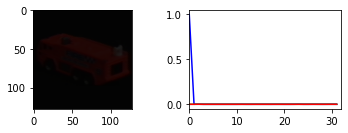

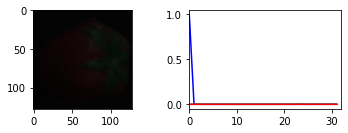

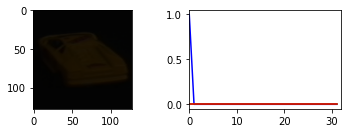

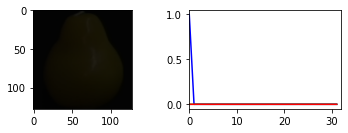

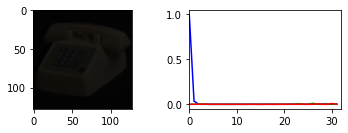

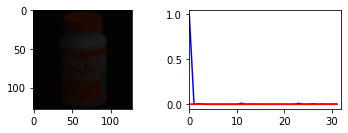

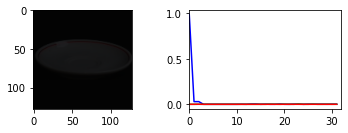

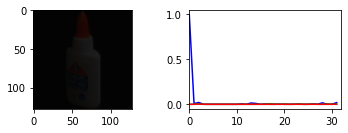

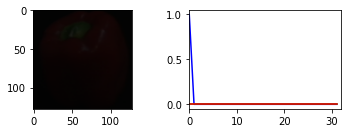

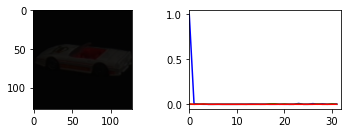

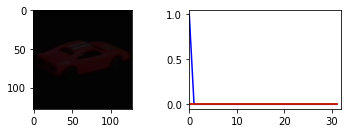

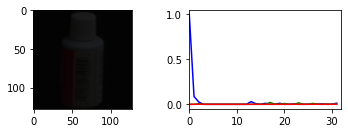

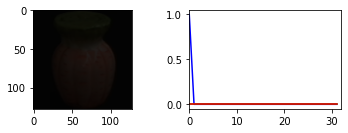

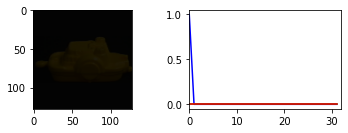

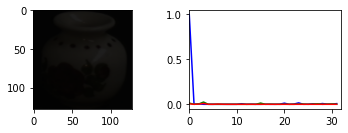

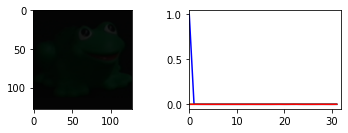

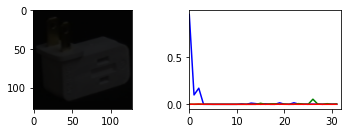

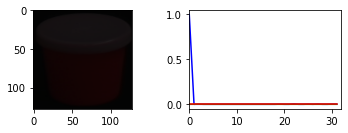

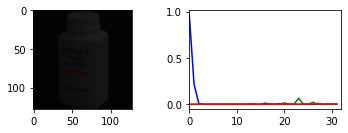

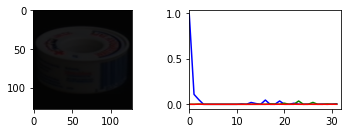

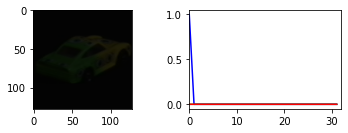

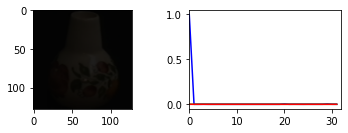

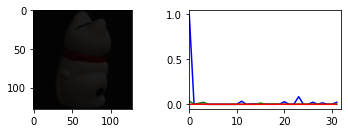

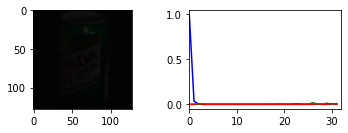

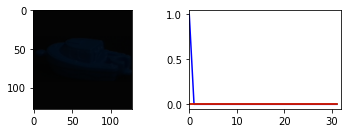

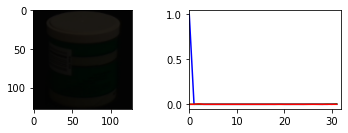

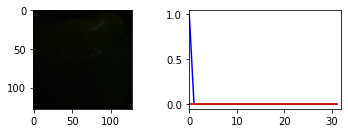

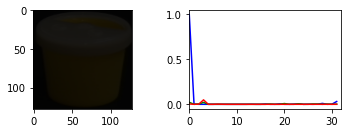

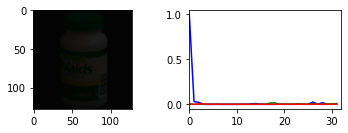

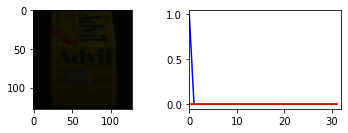

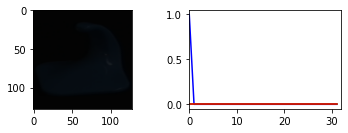

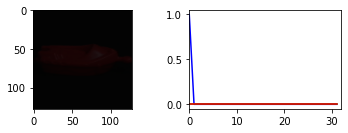

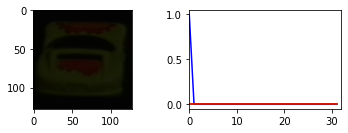

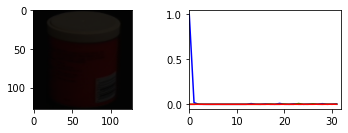

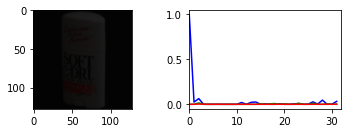

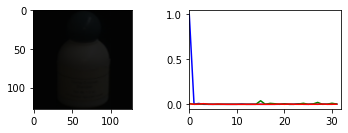

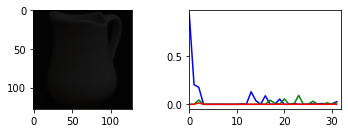

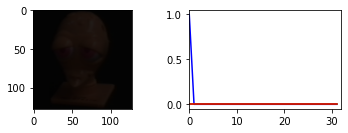

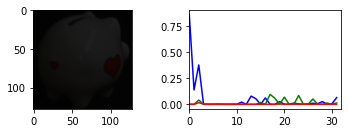

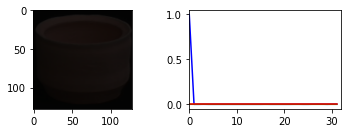

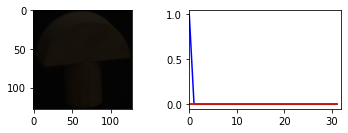

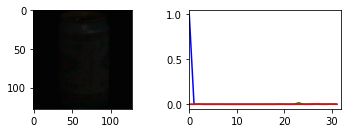

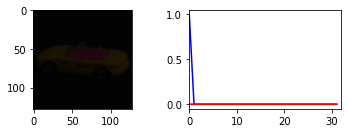

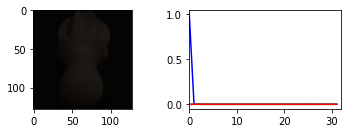

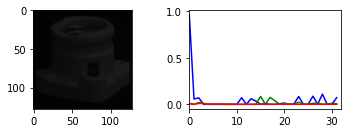

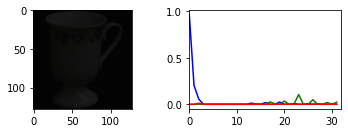

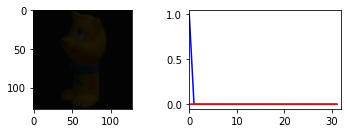

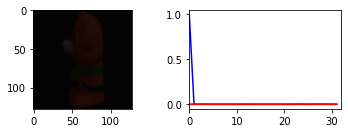

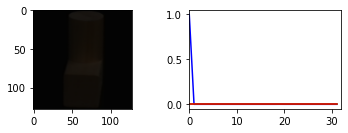

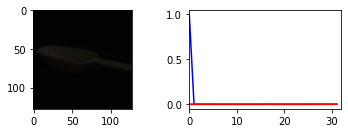

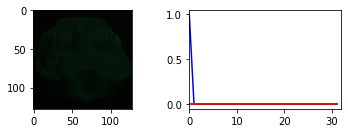

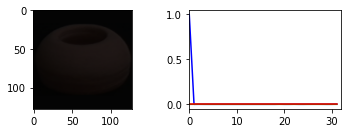

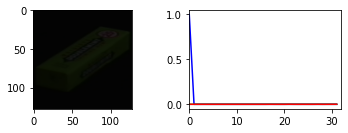

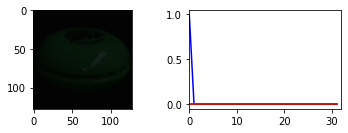

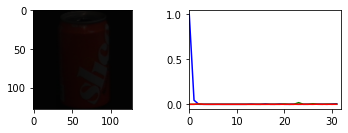

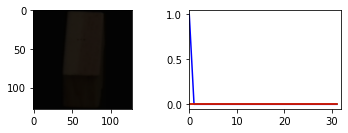

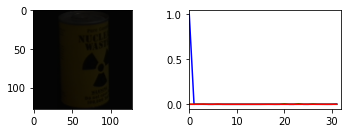

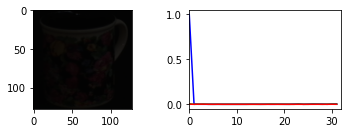

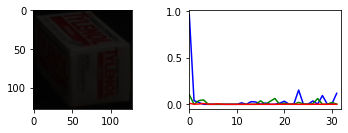

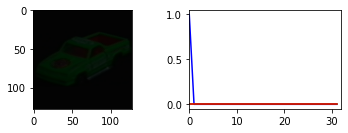

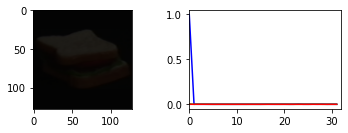

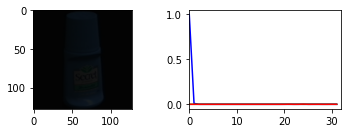

In [23]:
cf = evaluate(test = test_path, indexed_db = indexed_db)

In [24]:
# afficher matrice de confusion des 100 images requêtes
print(cf)

[[2. 0. 0. ... 0. 0. 0.]
 [0. 7. 1. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 ...
 [2. 0. 0. ... 2. 0. 0.]
 [3. 0. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 0. 0. 5.]]


### Dessiner la matrice des 100 requêtes (1 image / classe)
#### Nous constatons dans notre matrice de confusion, que chaque classe image requête nous avons au moins en moyenne 5 résultats images bonnes.
#### Fonction pour dessiner, la matrix de confusion 

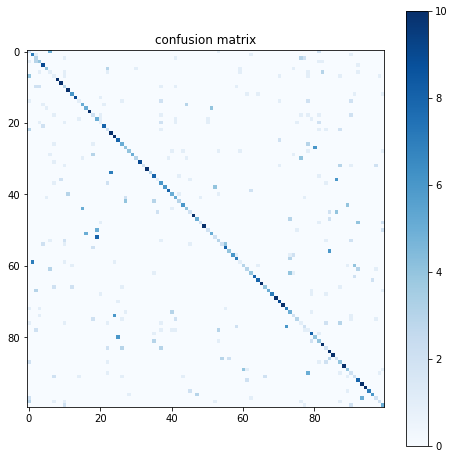

In [25]:
cf_matrix = cf
plt.figure(figsize=(8, 8))
plt.imshow(cf_matrix, interpolation='nearest', cmap='Blues')
plt.title('confusion matrix')
plt.colorbar()
plt.show()

### Performance obtenue sur l'evaluation de 100 images requêtes (1 image/ classe)

In [26]:
accuracy = np.trace(cf) / float(np.sum(cf))
print("Accuracy d'évaluation:  {}%\nErreur d'évaluation: {}%".format(accuracy * 100, (1-accuracy) * 100))

Accuracy d'évaluation:  53.6%
Erreur d'évaluation: 46.4%


###

# Test sur une image requête quelconque
### Fonction pour afficher les images résultats

In [27]:
def AfficherResultats(resultats = None):
    nb_columns = 5
    nb_line = 2
    fig, ax = plt.subplots(nb_line, nb_columns, sharex=True, sharey=True, figsize=(10,10))
    k = 0
    for i in range(nb_line):
        for j in range(nb_columns):
            img = cv2.imread(db_path + resultats[j + k])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i,j].imshow(img)
            ax[i,j].set_title(resultats[j + k])
        k = k + nb_columns

    plt.show()

### Test_ 1: image requete tasse. Nous obtenons 7 bons resultats proche de notre image rquête

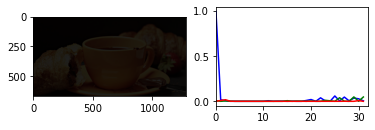

> recherche  --input  ./samples/tasse3.jpg 

Images                     Distances
------                     ---------
obj89__285.png		 0.25416747437108306

obj5__70.png		 0.29426953858779226

obj100__160.png		 0.3012093779041288

obj93__120.png		 0.3033520681053434

obj89__310.png		 0.31863819125783044

obj93__125.png		 0.32105905740283813

obj89__280.png		 0.33076254953040485

obj5__75.png		 0.3391318159720889

obj89__315.png		 0.34019530103234685

obj100__165.png		 0.36372628041734845



In [47]:
# image requete tasse
path_image_query = "./samples/tasse3.jpg"

resultats_noms, resultats_dist = RechercheImagesFromImageReq(path_image_query=path_image_query, indexed_db=indexed_db)

afficheResultats(image_query = path_image_query, resultats_noms = resultats_noms, resultats_dist = resultats_dist)

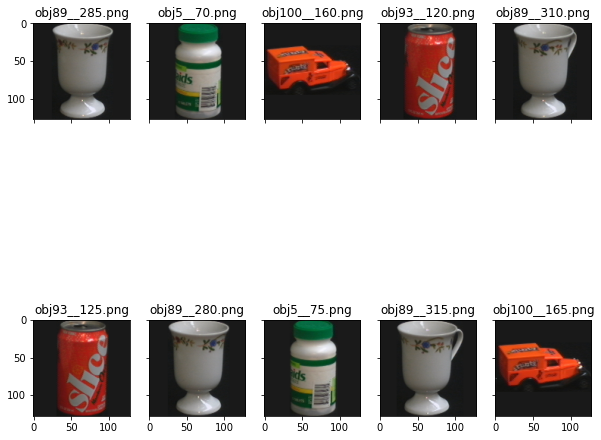

In [48]:
# Visualiser les résulatas
AfficherResultats(resultats = resultats_noms)

### Test 2 : tasse. 2 resultats proche en terme de forme et couleurs

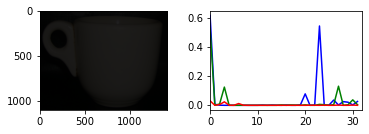

> recherche  --input  ./samples/tasse.png 

Images                     Distances
------                     ---------
obj74__95.png		 0.6093985457068822

obj4__60.png		 0.6196021228344107

obj4__55.png		 0.6417592032611261

obj4__65.png		 0.6987538893085781

obj41__300.png		 0.7407810406717503

obj85__45.png		 0.7752422967650846

obj97__255.png		 0.7827848951401883

obj85__310.png		 0.7932823286760796

obj32__75.png		 0.8206163513972884

obj65__330.png		 0.8221682178461702



In [49]:
# image requete tasse
path_image_query = "./samples/tasse.png"

resultats_noms, resultats_dist = RechercheImagesFromImageReq(path_image_query=path_image_query, indexed_db=indexed_db)

afficheResultats(image_query = path_image_query, resultats_noms = resultats_noms, resultats_dist = resultats_dist)

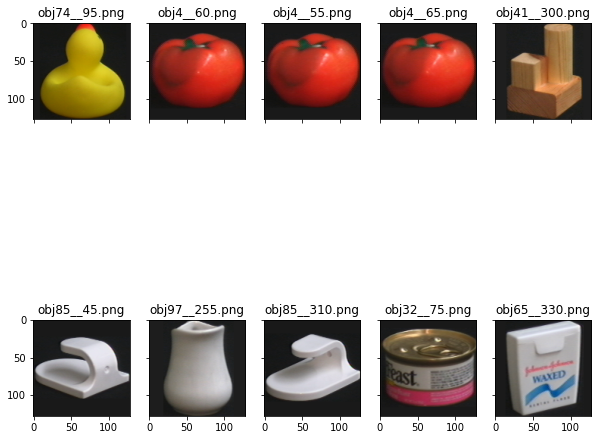

In [50]:
# Visualiser les résulatas
AfficherResultats(resultats = resultats_noms)

### Test 3 : Hambourger. 3 bons résultats

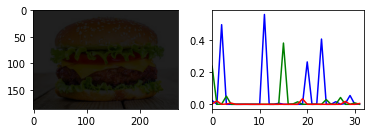

> recherche  --input  ./samples/hambourger.jpeg 

Images                     Distances
------                     ---------
obj73__320.png		 0.9031241644500464

obj73__325.png		 0.9976318954383006

obj87__65.png		 1.058335889041486

obj78__70.png		 1.0741789951709944

obj78__170.png		 1.075728736935989

obj63__110.png		 1.0928163244100957

obj73__330.png		 1.1009124818841936

obj99__45.png		 1.103016057163822

obj31__10.png		 1.148165403039525

obj27__60.png		 1.1644422868541726



In [51]:
# image requete tasse
path_image_query = "./samples/hambourger.jpeg"

resultats_noms, resultats_dist = RechercheImagesFromImageReq(path_image_query=path_image_query, indexed_db=indexed_db)

afficheResultats(image_query = path_image_query, resultats_noms = resultats_noms, resultats_dist = resultats_dist)

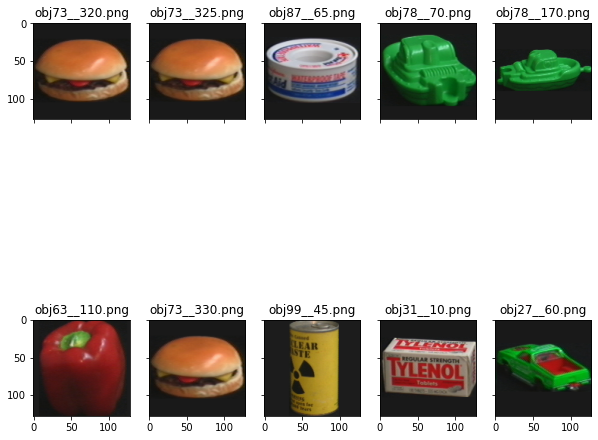

In [52]:
# Visualiser les résulatas
AfficherResultats(resultats = resultats_noms)

### Test 4: automobile (camion).  3 bons résultats, 2 vehicule proche par la forme

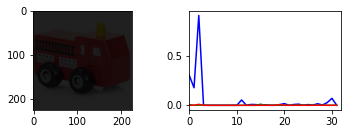

> recherche  --input  ./samples/bus.jpeg 

Images                     Distances
------                     ---------
obj19__85.png		 0.8527269560396527

obj19__275.png		 0.8891698071370397

obj69__100.png		 0.9577291299777142

obj19__270.png		 0.9854575776655956

obj64__170.png		 0.9867533530819786

obj27__290.png		 1.044483817069961

obj64__165.png		 1.0592222225278105

obj86__155.png		 1.0719599058144984

obj69__105.png		 1.0729339261859825

obj27__285.png		 1.081268448670453



In [53]:
# image requete tasse
path_image_query = "./samples/bus.jpeg"

resultats_noms, resultats_dist = RechercheImagesFromImageReq(path_image_query=path_image_query, indexed_db=indexed_db)

afficheResultats(image_query = path_image_query, resultats_noms = resultats_noms, resultats_dist = resultats_dist)

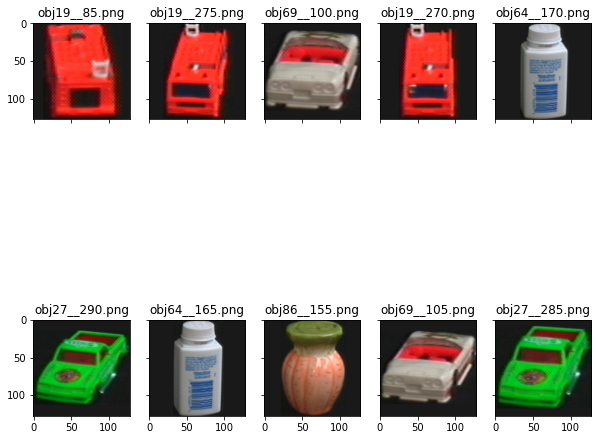

In [54]:
# Visualiser les résulatas
AfficherResultats(resultats = resultats_noms)

###  Test 5: canette coca. 8 bons résultats, 6 exactes par la couleur et la forme, et 2 par la forme. De même type.

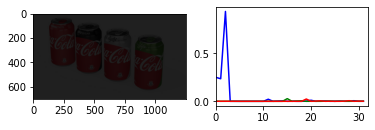

> recherche  --input  ./samples/canettecoca.jpg 

Images                     Distances
------                     ---------
obj62__285.png		 0.6024064212527838

obj15__115.png		 0.6055254867265143

obj62__290.png		 0.6087071114314204

obj93__10.png		 0.6661113306699513

obj62__150.png		 0.680838640382905

obj93__5.png		 0.6858060825188192

obj76__125.png		 0.6889885138463105

obj91__175.png		 0.7098616859587259

obj62__145.png		 0.7281231276428874

obj62__165.png		 0.7471437405055871



In [55]:
# image requete tasse
path_image_query = "./samples/canettecoca.jpg"

resultats_noms, resultats_dist = RechercheImagesFromImageReq(path_image_query=path_image_query, indexed_db=indexed_db)

afficheResultats(image_query = path_image_query, resultats_noms = resultats_noms, resultats_dist = resultats_dist)

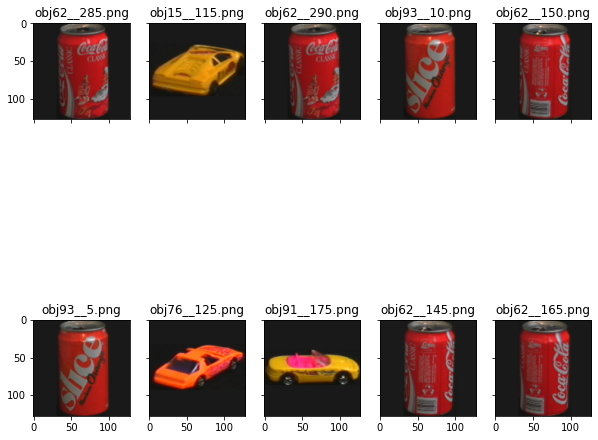

In [56]:
# Visualiser les résulatas
AfficherResultats(resultats = resultats_noms)

###  Nous notons que les resultats peuvenr être améliorés, en trouvant encore un meilleur ajustement des poids, ou en proposant une autre métrique plus éfficace en exploitant les métriques couleur et forme.